In [1]:
import scraper2 as s
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import seaborn as sns
from yahoo_fin import options
from yahoo_fin.stock_info import *
from yahoo_fin.stock_info import get_data, get_splits
import mibian
m = s.stockMongo()

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [4]:
op = m.stock_data.options_data2.find()
op.count()

C:\Users\ander\AppData\Local\Temp/ipykernel_37096/3622889483.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  op.count()


34

In [3]:
tick = "GOOG"
s.main2(tick)

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

Options where note stored


C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)
C:\Users\ander\Documents\yah

GOOG


In [31]:
apple = m.get_options("GOOG")
apple['time'] = apple['strike-date'] - apple.index
apple['time'] = apple['time'].dt.total_seconds() / (24 * 60 * 60)
apple = apple.reset_index()
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3172 entries, 2022-01-23 to 2022-01-23
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   % Change            3172 non-null   object        
 1   Ask                 3172 non-null   float64       
 2   Bid                 3166 non-null   float64       
 3   Change              3172 non-null   float64       
 4   Contract Name       3172 non-null   object        
 5   Implied Volatility  3172 non-null   object        
 6   Last Price          3172 non-null   float64       
 7   Last Trade Date     3172 non-null   object        
 8   Open Interest       3164 non-null   float64       
 9   Strike              3172 non-null   float64       
 10  Volume              2811 non-null   float64       
 11  strike-date         3172 non-null   datetime64[ns]
 12  type                3172 non-null   object        
dtypes: datetime64[ns](1), float64(

In [33]:
strike_dates = apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero).columns
#strike_dates
apple2 = apple[apple['strike-date']==strike_dates[1]]

In [34]:
apple2.describe()

,Ask,Bid,Change,Last Price,Open Interest,Strike,Volume,time
count,265.000000,264.000000,265.000000,265.000000,263.000000,265.000000,225.000000,265.0
mean,168.344717,161.975379,5.213849,132.265434,35.806084,2801.207547,15.977778,12.0
std,256.727835,252.249965,39.673106,207.985614,55.319720,428.396250,30.381421,0.0
min,0.050000,0.000000,-266.580000,0.010000,0.000000,1600.000000,1.000000,12.0
25%,6.300000,5.075000,-1.140000,6.510000,5.000000,2580.000000,2.000000,12.0
50%,39.700000,35.950000,0.000000,35.300000,14.000000,2830.000000,4.000000,12.0
75%,246.000000,232.225000,8.400000,175.450000,39.500000,3000.000000,15.000000,12.0
max,1255.800000,1239.600000,211.480000,1180.440000,353.000000,4200.000000,212.000000,12.0


In [37]:
last_price = 2600
vol = 0.25
strike_cols = apple2.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero).columns
above = strike_cols[strike_cols>last_price]
below = strike_cols[strike_cols<last_price]
aboveVol = strike_cols[strike_cols>last_price*(1+vol)]
belowVol = strike_cols[strike_cols<last_price*(1-vol)]
call1 = apple2[(apple2['Strike']==aboveVol[0])&(apple2['type']=='call')][['date', 'Last Price', 'strike-date']]
call1.columns = ['date', 'callLow', 'strike-date']
call2 = apple2[(apple2['Strike']==aboveVol[1])&(apple2['type']=='call')][['date', 'Last Price']]
call2.columns = ['date', 'callHigh']
put1 = apple2[(apple2['Strike']==belowVol[len(belowVol)-1])&(apple2['type']=='put')][['date', 'Last Price']]
put1.columns = ['date', 'putLow']
put2 = apple2[(apple2['Strike']==belowVol[len(belowVol)-2])&(apple2['type']=='put')][['date', 'Last Price']]
put2.columns = ['date', 'putHigh']

In [38]:
butterfly = call1.merge(call2, on='date', how='inner')
butterfly = butterfly.merge(put1, on='date', how='inner')
butterfly = butterfly.merge(put2, on='date', how='inner')
butterfly['condor'] = butterfly.callLow-butterfly.callHigh-butterfly.putHigh+butterfly.putLow
butterfly

,date,callLow,strike-date,callHigh,putLow,putHigh,condor
0,2022-01-23,3.5,2022-02-04,2.94,0.44,0.55,0.45


In [10]:
# set stock ticker symbol
stock_symbol = 'GOOG'
 
# set date range for historical prices
end_time = date.today()
start_time = end_time - timedelta(days=400)
 
# reformat date range
end = end_time.strftime('%Y-%m-%d')
start = start_time.strftime('%Y-%m-%d')
 
# get daily stock prices over date range
prices = get_data(stock_symbol, start, end, 'daily')

In [11]:
#compute daily returns and 20 day moving historical volatility
window_size = 20
prices['returns']=prices['close'].pct_change()
prices['volatility']=prices['returns'].rolling(window_size).std()*(252**0.5)
prices['date'] = prices.index
prices.tail()

,open,high,low,close,adjclose,volume,ticker,returns,volatility,date
2022-01-14,2750.000000,2824.010010,2750.000000,2795.729980,2795.729980,1190700,GOOG,0.004711,0.226708,2022-01-14
2022-01-18,2732.000000,2747.830078,2712.340088,2725.810059,2725.810059,1369100,GOOG,-0.025010,0.237711,2022-01-18
2022-01-19,2738.770020,2767.989990,2710.000000,2713.040039,2713.040039,1039800,GOOG,-0.004685,0.237866,2022-01-19
2022-01-20,2730.280029,2758.239990,2662.889893,2670.129883,2670.129883,1096500,GOOG,-0.015816,0.235446,2022-01-20
2022-01-21,2660.239990,2695.209961,2600.020020,2601.840088,2601.840088,2087000,GOOG,-0.025575,0.231579,2022-01-21


<AxesSubplot:>

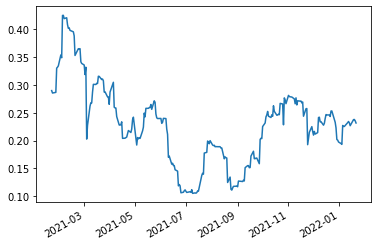

In [12]:
prices['volatility'].plot()

In [11]:
apple2 = apple.merge(prices[['close', 'volatility', 'date']], on='date')
apple2.head()

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility


In [62]:
apple['close'] = 164
apple['volatility'] = 0.30

In [41]:
#c = mibian.BS([8572, 8700, 0, 31], callPrice= 616.05).impliedVolatility
def iv(p):
    a = 200
    b = 200
    c = 5
    d = 2
    #return mibian.BS([p['c'], p['Strike'], 0, float(p['days'])], callPrice=p['Last Price']).impliedVolatility
    #return mibian.BS([1.4565, 1.45, 1, 30], volatility=20).callPrice
    try:
        if p['type'] == "call":
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], volatility=p['volatility']*100).callPrice
        else:
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], volatility=p['volatility']*100).putPrice
    except:
        value = NaN
    return value
    
        

<AxesSubplot:>

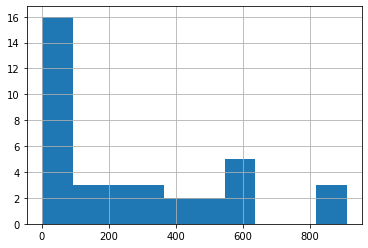

In [68]:
apple['value'] = apple.apply(iv, axis=1)
apple['diff'] = apple['Last Price'] - apple.value
#apple[apple['type']=='call'].plot(x='Strike', y='diff')
apple[apple['Open Interest']<2000]['Open Interest'].hist()

In [23]:
k = 8

strike_pivot = apple2.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns
new_apple2 = apple2.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])
calls = new_apple2.loc[('call', strike_cols[k])]
calls = calls.reset_index()
#
calls['Last Trade Date'] = pd.to_datetime(calls['Last Trade Date'])
calls['Last Trade Date'] = calls['Last Trade Date'].dt.strftime('%Y-%m-%d')
calls['Last Trade Date'] = pd.to_datetime(calls['Last Trade Date'])
calls = calls.loc[calls['Last Trade Date']==calls['date']]
calls

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  import sys
c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,type,strike-date,index,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,time,close,volatility
1,call,2021-03-05,32154,2021-01-28,-7.20%,32.90,31.85,-2.7,AAPL210305C00105000,59.38%,34.80,2021-01-28,1.0,105.0,5.0,36.0,137.089996,0.349932
3,call,2021-03-05,32156,2021-01-28,-5.73%,23.75,22.50,-1.58,AAPL210305C00115000,53.35%,26.00,2021-01-28,2.0,115.0,3.0,36.0,137.089996,0.349932
6,call,2021-03-05,32159,2021-01-28,-11.89%,19.50,18.10,-2.79,AAPL210305C00120000,50.98%,20.68,2021-01-28,114.0,120.0,40.0,36.0,137.089996,0.349932
7,call,2021-03-05,32160,2021-01-28,-19.49%,18.65,17.30,-4.78,AAPL210305C00121000,50.24%,19.75,2021-01-28,2.0,121.0,4.0,36.0,137.089996,0.349932
8,call,2021-03-05,32161,2021-01-28,-14.74%,17.90,16.50,-3.25,AAPL210305C00122000,50.24%,18.80,2021-01-28,5.0,122.0,2.0,36.0,137.089996,0.349932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,call,2021-03-05,79546,2021-02-24,-,0.02,0.01,0,AAPL210305C00160000,55.47%,0.03,2021-02-24,4845.0,160.0,646.0,9.0,125.349998,0.244821
1038,call,2021-03-05,79547,2021-02-24,-,0.02,0.01,0,AAPL210305C00162500,58.59%,0.01,2021-02-24,729.0,162.5,703.0,9.0,125.349998,0.244821
1039,call,2021-03-05,79548,2021-02-24,-50.00%,0.03,0.01,-0.01,AAPL210305C00165000,63.28%,0.01,2021-02-24,1729.0,165.0,61.0,9.0,125.349998,0.244821
1041,call,2021-03-05,79550,2021-02-24,+100.00%,0.02,0.01,0.01,AAPL210305C00170000,67.19%,0.02,2021-02-24,1127.0,170.0,106.0,9.0,125.349998,0.244821


In [32]:
lowcalls = calls.loc[calls['Strike'] < calls['close']*(1-calls['volatility']*factor)]
lowcalls = lowcalls.loc[lowcalls['time'] == 50]
lowcalls

,type,strike-date,index,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,time,close,volatility


In [30]:
factor = 0.5
lowcalls = calls.loc[calls['Strike'] < calls['close']*(1-calls['volatility']*factor)]
lowcalls = lowcalls.loc[lowcalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
lowcalls = lowcalls.loc[lowcalls['Last Price'] == min(lowcalls['Last Price'])]
midcalls = calls.loc[calls['Strike'] < calls['close']]
midcalls = midcalls.loc[midcalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
midcalls = midcalls.loc[midcalls['Last Price'] == min(midcalls['Last Price'])]
hicalls = calls.loc[calls['Strike'] > calls['close']*(1+calls['volatility']*factor)]
hicalls = hicalls.loc[hicalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
hicalls = hicalls.loc[hicalls['Last Price'] == max(hicalls['Last Price'])]

series = apple2.loc[apple2['time'] < 50].set_index('date')
low = series.loc[series['Contract Name']==lowcalls['Contract Name'].values[0]]
low['value'] = low.apply(iv, axis=1)
mid = series.loc[series['Contract Name']==midcalls['Contract Name'].values[0]]
mid['value'] = mid.apply(iv, axis=1)
hi = series.loc[series['Contract Name']==hicalls['Contract Name'].values[0]]
hi['value'] = hi.apply(iv, axis=1)
butterfly2 = low['Last Price'] - 2 * mid['Last Price'] + hi['Last Price']
butterfly = butterfly2.to_frame().reset_index()
value = low['value'] - 2* mid['value'] + hi['value']
value = value.to_frame().reset_index()
butterfly = butterfly.merge(value, on='date')
low = low.reset_index()
hi = hi.reset_index()
butterfly = butterfly.merge(low[['close', 'volatility', 'date', 'time','Strike']], on='date')
butterfly = butterfly.merge(hi[['date','Strike']], on='date')
butterfly['change'] = butterfly['Last Price'].pct_change()
np.mean(butterfly['change'])


ValueError: min() arg is an empty sequence

In [55]:

k = 7

strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

new_apple2 = new_apple.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])

apple_pivot_call = new_apple2.loc[('call', strike_cols[k])]
strike_pivot = apple_pivot_call.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_value_cols = strike_pivot.columns
apple_pivot_put = new_apple2.loc[('put', strike_cols[k])]
strike_pivot = apple_pivot_put.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_value_puts = strike_pivot.columns
#c = new_apple2['c'].mean()
c =132

cols = strike_value_cols[strike_value_cols > c]
puts = strike_value_puts[strike_value_puts < c]

puts = cols
apple_pivot_put = apple_pivot_call

df = apple_pivot_put[apple_pivot_put['Strike'] == puts[0]]
d = puts[0]
df.rename(columns = {'Last Price':str(d)}, inplace = True)
df = df[['date', str(d)]]


for i in range(1,len(puts)):
    df1 = apple_pivot_put[apple_pivot_put['Strike'] == puts[i]]
    df = pd.merge(df, df1[['date', 'Last Price']], on='date')
    df.rename(columns = {'Last Price': str(puts[i])}, inplace = True)

print(c)
print(strike_cols[k])
print(df)
df = df.set_index('date')
plt.figure(); df.plot(); plt.legend(loc='best')


NameError: name 'new_apple' is not defined

In [56]:
k = 14

strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

new_apple2 = new_apple.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])

NameError: name 'new_apple' is not defined

In [13]:
new_apple2.head()

level_0  index       date % Change   Ask    Bid Change  \
type strike-date                                                           
call 2021-01-08         0      0 2021-01-02   -1.61%  67.9  67.30  -1.11   
     2021-01-08         1      1 2021-01-02   -3.12%  62.9  62.30  -2.04   
     2021-01-08         2      2 2021-01-02        -  57.9  57.30      0   
     2021-01-08         3      3 2021-01-02        -  52.9  52.25      0   
     2021-01-08         4      4 2021-01-02   -2.54%  47.9  47.30  -1.24   

                        Contract Name Implied Volatility  Last Price  \
type strike-date                                                       
call 2021-01-08   AAPL210108C00065000            246.88%       67.64   
     2021-01-08   AAPL210108C00070000            223.44%       63.43   
     2021-01-08   AAPL210108C00075000            201.76%       56.44   
     2021-01-08   AAPL210108C00080000            181.25%       54.62   
     2021-01-08   AAPL210108C00085000            162.11%       47.63   

                         Last Trade Date  Open Interest  Strike  Volume   time  
type strike-date                                                                
call 2021-01-08   2020-12-31 11:25AM EST           38.0    65.0    32.0 6 days  
     2021-01-08    2020-12-31 9:46AM EST           13.0    70.0     5.0 6 days  
     2021-01-08   2020-12-23 11:38AM EST           54.0    75.0    50.0 6 days  
     2021-01-08    2020-12-29 3:54PM EST          167.0    80.0    91.0 6 days  
     2021-01-08    2020-12-31 3:55PM EST           55.0    85.0    65.0 6 days

In [16]:
cols

Float64Index([122.5, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0,
              165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0,
              210.0, 215.0, 220.0, 225.0, 230.0, 240.0, 250.0, 260.0, 270.0,
              280.0, 290.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0,
              335.0, 340.0, 345.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0,
              410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
              500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0,
              680.0, 700.0, 720.0, 740.0, 800.0, 900.0],
             dtype='float64', name='strike')

In [53]:
new_apple6[new_apple6['day']>30].dropna()['condor-change']

45   -0.002066
46   -0.002070
47   -0.002075
48   -0.002079
49   -0.002083
        ...   
25   -0.000909
26   -0.000910
27   -0.000911
28   -0.000912
29   -0.000912
Name: condor-change, Length: 18844, dtype: float64

In [24]:
new_apple[new_apple['time'].dt.days == 60]

,date,iv,last,strike,strike-date,type,time,c


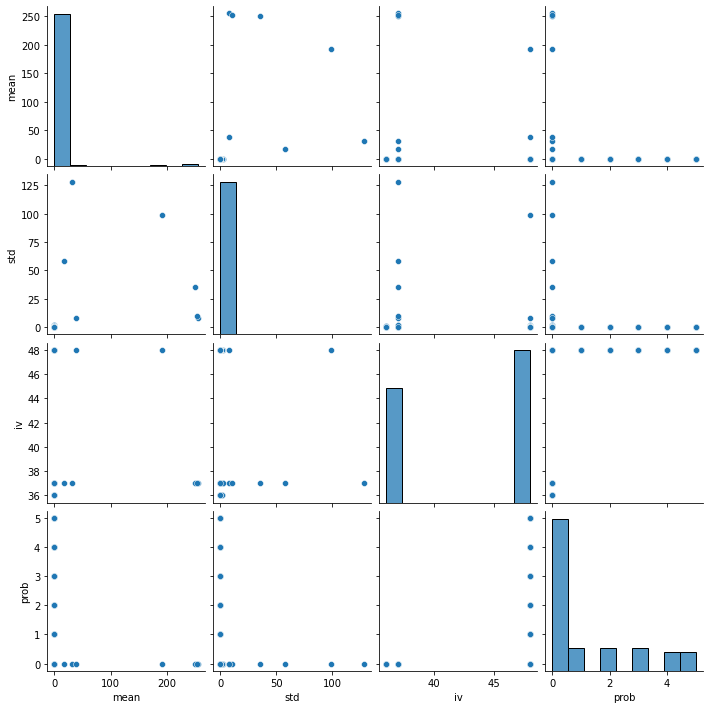

In [71]:
#new_apple5[['prob', 'condor-change', 'start', 'd-strike', 'day']].describe()
sns.pairplot(new_apple6[['mean','std','iv','prob']])
#sns.pairplot(new_apple5[new_apple5['d-strike'] == 3])

In [35]:
start = time.time()
new_apple5 = []
ivol = []

for k in range(13,16):
    new_apple2 = new_apple.reset_index()
    new_apple2 = new_apple2.set_index(['strike-date'])
    print(strike_cols[k])
    new_apple3 = new_apple2.loc[strike_cols[k]]
    
    for day in range(max(new_apple3['time']).days):
    
        new_apple4 = new_apple3[new_apple3['time'].dt.days == day]

        if len(new_apple4) > 0:
            new_apple4 = new_apple4.reset_index()
            iv2 = abs(new_apple4['strike'] - new_apple4['c'])
            iv = new_apple4.loc[iv2.idxmin()]['iv']
            c = new_apple4.loc[iv2.idxmin()]['c']
            date = new_apple4.loc[iv2.idxmin()]['date']
            strike_date = new_apple4.loc[iv2.idxmin()]['strike-date']
            ivol.append([date, iv])

            new_apple2 = new_apple2.reset_index()
            new_apple2 = new_apple2.set_index(['type','strike-date'])
            apple_pivot_call = new_apple2.loc[('Call', strike_cols[k])]
            strike_pivot = apple_pivot_call.pivot_table(columns="strike", values="date", aggfunc=np.count_nonzero)
            strike_value_cols = strike_pivot.columns
            apple_pivot_put = new_apple2.loc[('Put', strike_cols[k])]
            strike_pivot = apple_pivot_put.pivot_table(columns="strike", values="date", aggfunc=np.count_nonzero)
            strike_value_puts = strike_pivot.columns

            cols = strike_value_cols[strike_value_cols > c]

            new_apple2 = new_apple2.reset_index()
            new_apple2 = new_apple2.set_index(['type', 'strike', 'strike-date'])
            deltaStrikes = 3

            for i in range(len(cols)-deltaStrikes):
                minput = abs(strike_value_puts - 2*c + cols[i])
                put = strike_value_puts[minput==min(minput)][0]
                #Calculation for second put (insurance)
                puts = strike_value_puts ==put
                puts2 = np.arange(0,len(puts), 1)
                put2 = strike_value_puts[puts2[puts]-deltaStrikes]

                aCLo = new_apple2.loc[('Call', cols[i], strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aCLo = aCLo.reset_index()
                idx = pd.date_range(min(aCLo['date']), max(aCLo['date']), freq = "D")
                aCLo.index = pd.DatetimeIndex(aCLo.date)
                aCLo = aCLo.reindex(idx,fill_value=None)
                aCLo = aCLo.interpolate(method ='linear', limit_direction ='forward')
                aCLo = aCLo.drop(['type', 'strike-date', 'date'], axis=1)
                aCLo = aCLo.reset_index()
                aCLo.rename(columns = {'last':'priceCLo', 'strike':'strikeCLo', 'index': 'date'}, inplace = True)

                aCHi = new_apple2.loc[('Call', cols[i+deltaStrikes], strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aCHi = aCHi.reset_index()
                idx = pd.date_range(min(aCHi['date']), max(aCHi['date']), freq = "D")
                aCHi.index = pd.DatetimeIndex(aCHi.date)
                aCHi = aCHi.reindex(idx,fill_value=None)
                aCHi = aCHi.interpolate(method ='linear', limit_direction ='forward')
                aCHi = aCHi.drop(['type', 'strike-date', 'date'], axis=1)
                aCHi = aCHi.reset_index()
                aCHi.rename(columns = {'last':'priceCHi', 'strike':'strikeCHi', 'index': 'date'}, inplace = True)

                aPLo = new_apple2.loc[('Put', put2, strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aPLo = aPLo.reset_index()
                idx = pd.date_range(min(aPLo['date']), max(aPLo['date']), freq = "D")
                aPLo.index = pd.DatetimeIndex(aPLo.date)
                aPLo = aPLo.reindex(idx,fill_value=None)
                aPLo = aPLo.interpolate(method ='linear', limit_direction ='forward')
                aPLo = aPLo.drop(['type', 'strike-date', 'date'], axis=1)
                aPLo = aPLo.reset_index()
                aPLo.rename(columns = {'last':'pricePLo', 'strike':'strikePLo', 'index': 'date'}, inplace = True)

                aPHi = new_apple2.loc[('Put', put, strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aPHi = aPHi.reset_index()
                idx = pd.date_range(min(aPHi['date']), max(aPHi['date']), freq = "D")
                aPHi.index = pd.DatetimeIndex(aPHi.date)
                aPHi = aPHi.reindex(idx,fill_value=None)
                aPHi = aPHi.interpolate(method ='linear', limit_direction ='forward')
                aPHi = aPHi.drop(['type', 'strike-date', 'date'], axis=1)
                aPHi = aPHi.reset_index()
                aPHi.rename(columns = {'last':'pricePHi', 'strike':'strikePHi', 'index': 'date'}, inplace = True)

                a = pd.merge(aCLo, aCHi, on=['date', 'c'])
                a = pd.merge(a, aPLo, on=['date', 'c'])
                a = pd.merge(a, aPHi, on=['date', 'c'])
                #a = a.set_index('date')
                a['condor'] = a['priceCLo'] - a['priceCHi'] + a['pricePHi'] - a['pricePLo']
                a['prob'] = (cols[i] - c) / c
                a['strike-date'] = strike_date
                a['condor-change'] = a['condor'].pct_change()
                a = a[a['date'] > date]
                a['start'] = day
                if len(a) >= 5:
                    new_apple5.append(a)

new_apple5 = pd.concat(new_apple5)
new_apple5 = new_apple5.replace([np.inf, -np.inf], np.nan)
ivol = pd.DataFrame(data=ivol, columns=["date", "iv"])
end = time.time()
print(end - start)
    
    

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.


In [9]:
new_apple = new_apple.reset_index()
strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_date_cols = strike_pivot.columns
strike_pivot = new_apple.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

In [13]:
new_apple2 = new_apple
new_apple2 = new_apple2.set_index(['type', 'strike-date', 'Strike'])

In [19]:
new_apple2.loc['put', strike_date_cols[19], 220]

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


level_0  index       date % Change    Ask     Bid  \
type strike-date Strike                                                      
put  2023-01-20  220.0       298    298 2020-11-19        -    0.0    0.00   
                 220.0       698    698 2020-11-21        -    0.0    0.00   
                 220.0      1093   1093 2020-11-23        -    0.0    0.00   
                 220.0      1493   1493 2020-11-25        -    0.0    0.00   
                 220.0      3128   3128 2020-11-26        -  107.9  106.25   
                 220.0      3947   3947 2020-11-27        -    0.0    0.00   
                 220.0      4342   4342 2020-11-28        -    0.0    0.00   
                 220.0      4737   4737 2020-11-29        -    0.0    0.00   
                 220.0      5028   5028 2020-11-30        -    0.0    0.00   
                 220.0      5319   5319 2020-12-02        -    0.0    0.00   
                 220.0      5714   5714 2020-12-03        -    0.0    0.00   
                 220.0      6109   6109 2020-12-04        -    0.0    0.00   
                 220.0      6400   6400 2020-12-05        -    0.0    0.00   
                 220.0      6691   6691 2020-12-06        -    0.0    0.00   
                 220.0      6982   6982 2020-12-07        -    0.0    0.00   
                 220.0      7273   7273 2020-12-08        -    0.0    0.00   
                 220.0      7780   7780 2020-12-09        -    0.0    0.00   
                 220.0      8071   8071 2020-12-10        -    0.0    0.00   
                 220.0      8362   8362 2020-12-10        -    0.0    0.00   
                 220.0      8653   8653 2020-12-11        -    0.0    0.00   
                 220.0      8944   8944 2020-12-11        -    0.0    0.00   
                 220.0     11861  11861 2020-12-12   +3.48%  103.4  101.35   
                 220.0     14778  14778 2020-12-13   +3.48%  103.4  101.35   
                 220.0     17713  17713 2020-12-15   +2.05%  103.3  101.75   
                 220.0     17908  17908 2020-12-17        -    0.0    0.00   

                        Change        Contract Name Implied Volatility  \
type strike-date Strike                                                  
put  2023-01-20  220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000             34.71%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0    3.48  AAPL230120P00220000             36.67%   
                 220.0    3.48  AAPL230120P00220000             36.69%   
                 220.0    2.05  AAPL230120P00220000             35.4